In [ ]:
!pip install opencv-python==4.5.1.48
!pip install opencv-contrib-python
!pip install --upgrade --force-reinstall kaggle

     |████████████████████████████████| 50.4MB 56kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 61kB 2.5MB/s 
     |████████████████████████████████| 153kB 5.2MB/s 
     |████████████████████████████████| 235kB 37.2MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 143kB 38.7MB/s 
     |████████████████████████████████| 184kB 37.2MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=c4f845ca2059cb0914a9dc5e590e24d018fa475132cadf1458f0b269abb2906d
  Stored in directory: /root/.

In [234]:
import os
import pickle
import numpy as np
import cv2
import math
import random
import time
import pickle
import joblib
import tensorflow as tf
import shutil
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from skimage.transform import pyramid_gaussian, pyramid_expand
from google.colab.patches import cv2_imshow

Full dataset:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
%cd /content
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip -d cat_dog_full
%cd cat_dog_full/
!unzip train.zip 

In [ ]:
%cd /content/

LABELS = {0: "Cat", 1: "Dog"}
ROOT = "cat_dog_full"

train_data = []
train_label = []
test_data = []
test_label = []
data = []
label = []

for fn in tqdm(os.listdir(ROOT + "/train")):
    if "cat" not in fn and "dog" not in fn:
        continue
    img = ROOT + "/train/" + fn
    data.append(img)
    label.append(0 if "cat" in fn else 1)

train_fraction = int(0.8 * len(data))

train_data, test_data = data[:train_fraction], data[train_fraction:]
train_label, test_label = label[:train_fraction], label[train_fraction:]

print(len(train_data), len(train_label))
print(len(test_data), len(test_label))
print(train_label[0])

100%|██████████| 25000/25000 [00:00<00:00, 1175533.63it/s]

/content
20000 20000
5000 5000
0


Dogs vs Cats small dataset:

In [ ]:
%cd /content/
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 
!unzip cats_and_dogs_filtered.zip
!mv cats_and_dogs_filtered cat_dog

/content
--2021-06-13 02:44:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   101MB/s    in 0.6s    

2021-06-13 02:44:53 (101 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/va

In [ ]:
%cd /content/

LABELS = {0: "Cat", 1: "Dog"}
ROOT = "cat_dog"

train_data = []
train_label = []
test_data = []
test_label = []

for fn in os.listdir(ROOT + "/train/cats"):
    img = ROOT + "/train/cats/" + fn
    train_data.append(img)
    train_label.append(0)
for fn in os.listdir(ROOT + "/train/dogs"):
    img = ROOT + "/train/dogs/" + fn
    train_data.append(img)
    train_label.append(1)

for fn in os.listdir(ROOT + "/validation/cats"):
    img = ROOT + "/validation/cats/" + fn
    test_data.append(img)
    test_label.append(0)
for fn in os.listdir(ROOT + "/validation/dogs"):
    img = ROOT + "/validation/dogs/" + fn
    test_data.append(img)
    test_label.append(1)

print(len(train_data), len(train_label))
print(len(test_data), len(test_label))
print(train_label[0])

/content
2000 2000
1000 1000
0


Cats vs Non-cats:

In [ ]:
%cd /content/
!gdown --id 1sw4_l0Ua6qFAFedbzX-oxRJ3ELsazNTO
!unzip cats_and_noncats.zip -d cats_and_noncats

/content
Downloading...
From: https://drive.google.com/uc?id=1sw4_l0Ua6qFAFedbzX-oxRJ3ELsazNTO
To: /content/cats_and_noncats.zip
277MB [00:02, 95.8MB/s]
Archive:  cats_and_noncats.zip
   creating: cats_and_noncats/validation/
   creating: cats_and_noncats/validation/cats/
  inflating: cats_and_noncats/validation/cats/cat.2000.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2001.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2002.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2003.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2004.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2005.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2006.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2007.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2008.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2009.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2010.jpg  
  inflating: cats_and_noncats/validation/cats/cat.2011.j

In [ ]:
%cd /content/

LABELS = {0: "Cat", 1: "Non-Cat"}
ROOT = "cats_and_noncats"

train_data = []
train_label = []
test_data = []
test_label = []

for fn in os.listdir(ROOT + "/train/cats"):
    img = ROOT + "/train/cats/" + fn
    train_data.append(img)
    train_label.append(0)
for fn in os.listdir(ROOT + "/train/noncats"):
    img = ROOT + "/train/noncats/" + fn
    train_data.append(img)
    train_label.append(1)

for fn in os.listdir(ROOT + "/validation/cats"):
    img = ROOT + "/validation/cats/" + fn
    test_data.append(img)
    test_label.append(0)
for fn in os.listdir(ROOT + "/validation/noncats"):
    img = ROOT + "/validation/noncats/" + fn
    test_data.append(img)
    test_label.append(1)

print(len(train_data), len(train_label))
print(len(test_data), len(test_label))
print(train_label[0])

/content
2000 2000
1000 1000
0


Cifar 10:

In [ ]:
%cd /content
!rm -rf cifar10
!git clone https://github.com/YoongiKim/CIFAR-10-images.git
!mv CIFAR-10-images cifar10

/content
Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 21.82 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


In [ ]:
DATA_ROOT = "/content/cifar10"

LABELS = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
          4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship',
          9: 'truck'}
REV_LABELS = dict([(y, x) for x, y in LABELS.items()])

train_data = []
train_label = []
test_data = []
test_label = []

for d in os.listdir(DATA_ROOT + "/train"):
    if d not in LABELS.values():
        continue
    for fn in os.listdir(DATA_ROOT + "/train/" + d):
        if fn[-3:] != "jpg":
            continue
        train_data.append(DATA_ROOT + "/train/" + d + "/" + fn)
        train_label.append(REV_LABELS[d])

for d in os.listdir(DATA_ROOT + "/test"):
    if d not in LABELS.values():
        continue
    for fn in os.listdir(DATA_ROOT + "/test/" + d):
        if fn[-3:] != "jpg":
            continue
        test_data.append(DATA_ROOT + "/test/" + d + "/" + fn)
        test_label.append(REV_LABELS[d])

print(len(train_data), len(train_label))
print(len(test_data), len(test_label))
print(train_data[0])
print(train_label[0])

50000 50000
10000 10000
/content/cifar10/train/horse/2193.jpg
7


In [ ]:
# for i in range(len(train_data)):
#     train_data[i] = cv2.resize(train_data[i], (256, 256))
# for i in range(len(test_data)):
#     test_data[i] = cv2.resize(test_data[i], (256, 256))

TypeError: ignored

In [ ]:
PROB = 0.01
def draw_kp(img, gray, kp):
    if random.random() > 1-PROB:
        return
    img_ = img.copy()
    cv2.drawKeypoints(gray, kp, img_)
    img_ = cv2.resize(img_, (256, 256))
    cv2.imwrite("/content/output/%i.jpg" % (int(time.time())), img_)

In [ ]:
%cd /content
!mkdir output
!rm -rf output/*.*

# K = 800
# K = 400
K = 4000
# K = 10000
STEP_SIZE = 3

# bow = cv2.BOWKMeansTrainer(K)
bow = cv2.BOWKMeansTrainer(K, termcrit=(cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1))

detector = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.1)
extractor = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.1)
detector = cv2.SIFT_create(nfeatures=100, contrastThreshold=0.09)
extractor = cv2.SIFT_create(nfeatures=100, contrastThreshold=0.09)
detector = cv2.SIFT_create()
extractor = cv2.SIFT_create()
# detector = cv2.ORB_create()
# extractor = cv2.ORB_create()
ignore_list = []

print("Adding feature descriptors to dictionary...")
for i in tqdm(range(len(train_data))):
    img = cv2.imread(train_data[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray = img
    # kp = [cv2.KeyPoint(x, y, STEP_SIZE) for y in range(0, gray.shape[0], STEP_SIZE) 
    #                                     for x in range(0, gray.shape[1], STEP_SIZE)]
    # new_kp, des = detector.compute(gray, kp)
    kp, des = detector.detectAndCompute(gray, None)
    draw_kp(img, gray, kp)
    if des is not None:
        bow.add(des)
    else:
        ignore_list.append(i)
print(des.shape)

/content


  0%|          | 1/2000 [00:00<03:45,  8.87it/s]

Adding feature descriptors to dictionary...


100%|██████████| 2000/2000 [03:46<00:00,  8.85it/s]

(1154, 128)


In [ ]:
def remove_list_of_indices(my_list, inds):
    new_list = []
    for i in range(len(my_list)):
        if i not in inds:
            new_list.append(my_list[i])
    return new_list

In [ ]:
print("Can't extract features from samples:", ignore_list)
train_data = remove_list_of_indices(train_data, ignore_list)
train_label = remove_list_of_indices(train_label, ignore_list)
print("New shape for training data:", len(train_data))

print("Number of descriptors:", bow.descriptorsCount())

print("Clustering...")
begin = time.time()
dictionary = bow.cluster()
print("Done clustering in %.2fs" % (time.time()-begin))

bow_dict = cv2.BOWImgDescriptorExtractor(extractor, cv2.BFMatcher(cv2.NORM_L2))
bow_dict.setVocabulary(dictionary)
print("BOW dictionary shape:", np.shape(dictionary))

Can't extract features from samples: []
New shape for training data: 2000
Number of descriptors: 1924547
Clustering...
Done clustering in 8481.96s
BOW dictionary shape: (4000, 128)


In [ ]:
with open("/content/vocab.pkl", "wb") as file:
    pickle.dump(dictionary, file)
    file.close()

In [ ]:
detector = cv2.SIFT_create(nfeatures=100, contrastThreshold=0.09)
extractor = cv2.SIFT_create(nfeatures=100, contrastThreshold=0.09)
detector = cv2.SIFT_create()
extractor = cv2.SIFT_create()

with open("/content/vocab.pkl", "rb") as file:
    dictionary = pickle.load(file)
    file.close()
bow_dict = cv2.BOWImgDescriptorExtractor(extractor, cv2.BFMatcher(cv2.NORM_L2))
bow_dict.setVocabulary(dictionary)
print("BOW dictionary shape:", np.shape(dictionary))

BOW dictionary shape: (4000, 128)


In [ ]:
def feature_extract(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray_img = image
    des = detector.detect(gray_img)
    return bow_dict.compute(gray_img, des)
# def feature_extract(image):
#     return bow_dict.compute(image, detector.detect(image))

In [ ]:
print("Encoding train set...")
train_set = None
for i in tqdm(range(len(train_data))):
    features = feature_extract(cv2.imread(train_data[i]))
    if features is None:
        features = np.zeros((1, dictionary.shape[0]))
    if train_set is None:
        train_set = features
    else:
        train_set = np.append(train_set, features, axis=0)

print("Encoding test set...")
test_set = None
for i in tqdm(range(len(test_data))):
    features = feature_extract(cv2.imread(test_data[i]))
    if features is None:
        features = np.zeros((1, dictionary.shape[0]))
    if test_set is None:
        test_set = features
    else:
        test_set = np.append(test_set, features, axis=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

Encoding train set...


  0%|          | 1/1000 [00:00<02:35,  6.41it/s]

Encoding test set...


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


In [ ]:
print(train_set.shape)
print(test_set.shape)

(2000, 800)
(1000, 800)


In [ ]:
with open("/content/train.pkl", "wb") as file:
    pickle.dump(train_set, file)
    file.close()
with open("/content/test.pkl", "wb") as file:
    pickle.dump(test_set, file)
    file.close()

In [ ]:
with open("/content/train.pkl", "rb") as file:
    train_set = pickle.load(file)
    file.close()
with open("/content/test.pkl", "rb") as file:
    test_set = pickle.load(file)
    file.close()

In [ ]:
scale = joblib.load("/content/scaler.joblib")

In [ ]:
WORKERS = 10

scale = StandardScaler().fit(train_set)
joblib.dump(scale, "/content/scaler.joblib")
train_set_final_s = scale.transform(train_set)
test_set_final_s = scale.transform(test_set)

train_set_final_sn = normalize(scale.transform(train_set))
test_set_final_sn = normalize(scale.transform(test_set))

train_set_final_n = normalize(train_set)
test_set_final_n = normalize(test_set)

train_set_final = train_set
test_set_final = test_set

print(train_set_final.shape)
print(len(train_label))
print(test_set_final.shape)
print(len(test_label))

hyperparams = {"n_estimators": [50, 100, 500, 1000, 2000, 5000],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 5, 8, 15, 25],
              "min_samples_split": [1, 2, 5, 10, 15, 100],
              "min_samples_leaf": [1, 2, 5, 10],
              "max_features": ["sqrt", "log2"]}
rf = RandomForestClassifier()
clf = RandomizedSearchCV(rf, hyperparams, n_jobs=WORKERS, verbose=2, n_iter=50, cv=3)
# clf = RandomForestClassifier(n_estimators=5000, n_jobs=2, min_samples_split=15, min_samples_leaf=5, max_features='log2', max_depth=8, criterion='gini')
# clf = RandomForestClassifier(n_estimators=5000,  n_jobs=2, criterion="entropy", max_features="log2")
# clf = RandomForestClassifier(n_estimators=50, n_jobs=2, min_samples_split=15, min_samples_leaf=2, max_features='log2', max_depth=15, criterion='gini')
# clf = RandomForestClassifier(n_estimators=5000, n_jobs=2, min_samples_split=15, min_samples_leaf=1, max_features='log2', max_depth=8, criterion='gini')
clf.fit(train_set_final, train_label)
print("Random forest:")
try:
    print("Best params:", clf.best_params_)
except:
    pass
print("On testset:")
pred = clf.predict(test_set_final)
print(classification_report(pred, test_label, digits=4))
print("On trainset:")
pred = clf.predict(train_set_final)
print(classification_report(pred, train_label, digits=4))
joblib.dump(clf, "/content/rf.joblib")

hyperparams = {'C': [0.1, 1, 5, 10, 100], "kernel": ["rbf", "linear"]}
svc = SVC()
clf = GridSearchCV(svc, hyperparams, n_jobs=WORKERS, verbose=2, cv=3)
# clf = SVC(C=1, kernel="rbf")
clf.fit(train_set_final_n, train_label)
print("SVM:")
try:
    print("Best params:", clf.best_params_)
except:
    pass
print("On testset:")
pred = clf.predict(test_set_final_n)
print(classification_report(pred, test_label, digits=4))
print("On trainset:")
pred = clf.predict(train_set_final_n)
print(classification_report(pred, train_label, digits=4))
joblib.dump(clf, "/content/svm.joblib")

k = int(math.sqrt(train_set.shape[0]))
k = k if k&1 else k+1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(train_set_final_sn, train_label)
print("KNN:")
print("On testset:")
pred = clf.predict(test_set_final)
print(classification_report(pred, test_label, digits=4))
print("On trainset:")
pred = clf.predict(train_set_final)
print(classification_report(pred, train_label, digits=4))
joblib.dump(clf, "/content/knn.joblib")

clf = MultinomialNB()
clf.fit(train_set_final, train_label)
print("MultinomialNB:")
print("On testset:")
pred = clf.predict(test_set_final)
print(classification_report(pred, test_label, digits=4))
print("On trainset:")
pred = clf.predict(train_set_final)
print(classification_report(pred, train_label, digits=4))
joblib.dump(clf, "/content/mnb.joblib")

hyperparams = {"solver": ['newton-cg', 'lbfgs', 'liblinear'],
              "multi_class": ['auto'],
              "penalty": ['l2'],
              "C": [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression()
clf = GridSearchCV(lr, hyperparams, n_jobs=WORKERS, verbose=2)
# clf = LogisticRegression(C=1, multi_class="auto", penalty="l2", solver="newton-cg")
clf.fit(train_set_final_sn, train_label)
print("Logistic Regression:")
print("Best params:", clf.best_params_)
print("On testset:")
pred = clf.predict(test_set_final)
print(classification_report(pred, test_label, digits=4))
print("On trainset:")
pred = clf.predict(train_set_final)
print(classification_report(pred, train_label, digits=4))
joblib.dump(clf, "/content/lr.joblib")

In [ ]:
train_set_final = train_set
test_set_final = test_set
train_set_final_sn = normalize(scale.transform(train_set))
test_set_final_sn = normalize(scale.transform(test_set))
train_set_final_n = normalize(train_set)
test_set_final_n = normalize(test_set)

print("SVM")

# clf = SVC(C=1, kernel="linear", decision_function_shape="ovr", probability=True)
# clf.fit(train_set_final_n, train_label)
# joblib.dump(clf, "svm-prob.joblib")

clf = joblib.load("/content/svm-prob.joblib")

print("On trainset:")
begin = time.time()
pred = clf.predict(train_set_final_n)
print("Avg FPS: %.4f" % (train_set_final_n.shape[0]/(time.time()-begin)))
print(classification_report(pred, train_label, digits=4))

print("On testset:")
# begin = time.time()
# print("Encoding test set...")
# test_set = None
# for i in tqdm(range(len(test_data))):
#     features = feature_extract(cv2.imread(test_data[i]))
#     if features is None:
#         features = np.zeros((1, dictionary.shape[0]))
#     if test_set is None:
#         test_set = features
#     else:
#         test_set = np.append(test_set, features, axis=0)
# test_set_final_n = normalize(test_set)
pred = clf.predict(test_set_final_n)
print("Avg FPS: %.4f" % (test_set_final_n.shape[0]/(time.time()-begin)))
print(classification_report(pred, test_label, digits=4))

%cd /content/
!rm -rf wrong_prediction
!mkdir wrong_prediction
for i in range(test_set_final_sn.shape[0]):
    if pred[i] == test_label[i]:
        continue
    shutil.copyfile(test_data[i], "/content/wrong_prediction/%s-%i.jpg" % ("cat" if pred[i] == 0 else "noncat", i))    

SVM
On trainset:
Avg FPS: 145.3422
              precision    recall  f1-score   support

           0     0.9780    0.9790    0.9785       999
           1     0.9790    0.9780    0.9785      1001

    accuracy                         0.9785      2000
   macro avg     0.9785    0.9785    0.9785      2000
weighted avg     0.9785    0.9785    0.9785      2000

On testset:
Avg FPS: 48.2707
              precision    recall  f1-score   support

           0     0.8820    0.8855    0.8838       498
           1     0.8860    0.8825    0.8842       502

    accuracy                         0.8840      1000
   macro avg     0.8840    0.8840    0.8840      1000
weighted avg     0.8840    0.8840    0.8840      1000

/content


Neural network:

In [ ]:
scale = StandardScaler().fit(train_set)
train_set_final = normalize(scale.transform(train_set))
test_set_final= normalize(scale.transform(test_set))
train_set_final = train_set
test_set_final = test_set
train_set_final = normalize(train_set)
test_set_final= normalize(test_set)

train_label_final = np.array(train_label).reshape((-1, 1))
test_label_final = np.array(test_label).reshape((-1, 1))

test_ds = np.append(test_set_final, test_label_final, axis=1)
np.random.shuffle(test_ds)
test_set_final, test_label_final = test_ds[:, :-1], test_ds[:, -1:]

test_set_final, val_set_final, test_label_final, val_label_final = train_test_split(test_set_final, test_label_final, test_size=0.5)

joblib.dump((train_set_final, train_label_final, test_set_final, test_label_final, val_set_final, val_label_final), "/content/nn_dataset.joblib")

['/content/nn_dataset.joblib']

In [ ]:
train_set_final, train_label_final, test_set_final, test_label_final, val_set_final, val_label_final = joblib.load("/content/nn_dataset.joblib")

In [ ]:
BATCH_SIZE = 16

print(train_set_final.shape, train_label_final.shape)
print(val_set_final.shape, val_label_final.shape)
print(test_set_final.shape, test_label_final.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((train_set_final, train_label_final))
val_dataset = tf.data.Dataset.from_tensor_slices((val_set_final, val_label_final))
test_dataset = tf.data.Dataset.from_tensor_slices((test_set_final, test_label_final))

print("Val")
for feat, targ in val_dataset.take(10):
    print ('Features: {}, Label: {}'.format(feat, targ))

# batchs the dataset
train_dataset = train_dataset.shuffle(train_set_final.shape[0]).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(val_set_final.shape[0]).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(test_set_final.shape[0]).batch(BATCH_SIZE)

In [ ]:
n = train_set_final.shape[1]

model = tf.keras.Sequential([                         
    tf.keras.layers.Dense(n, activation="relu"),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
            #   optimizer="adam",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics="accuracy")

In [ ]:
%cd /content/
!mkdir checkpoint
EPOCHS = 60
CHECKPOINT_PATH = "/content/checkpoint/cat_dog.ckpt"

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch < 45:
        return lr * 10
    else:
        return lr * 50

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS,
                    callbacks=[lr_scheduler_callback, cp_callback])

/content
mkdir: cannot create directory ‘checkpoint’: File exists
Epoch 1/60
125/125 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.5175 - val_loss: 0.6926 - val_accuracy: 0.5140
Epoch 2/60
125/125 [==============================] - 1s 5ms/step - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6914 - val_accuracy: 0.5580
Epoch 3/60
125/125 [==============================] - 1s 6ms/step - loss: 0.6905 - accuracy: 0.5915 - val_loss: 0.6901 - val_accuracy: 0.5860
Epoch 4/60
125/125 [==============================] - 1s 5ms/step - loss: 0.6892 - accuracy: 0.5980 - val_loss: 0.6886 - val_accuracy: 0.6180
Epoch 5/60
125/125 [==============================] - 1s 5ms/step - loss: 0.6875 - accuracy: 0.6465 - val_loss: 0.6870 - val_accuracy: 0.6260
Epoch 6/60
125/125 [==============================] - 1s 5ms/step - loss: 0.6858 - accuracy: 0.6645 - val_loss: 0.6854 - val_accuracy: 0.6240
Epoch 7/60
125/125 [==============================] - 1s 5ms/step - loss: 0.6839 -

Inference tool:

In [ ]:
def non_maximum_suppression(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [281]:
detector = cv2.SIFT_create()
extractor = cv2.SIFT_create()

with open("/content/vocab.pkl", "rb") as file:
    dictionary = pickle.load(file)
    file.close()
bow_dict = cv2.BOWImgDescriptorExtractor(extractor, cv2.BFMatcher(cv2.NORM_L2))
bow_dict.setVocabulary(dictionary)
print("BOW dictionary shape:", np.shape(dictionary))

def feature_extract(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # cv2.imwrite("/content/blah/img.jpg", gray_img)
    des = detector.detect(gray_img)
    return bow_dict.compute(gray_img, des)

def get_bow_represention(img):
    features = feature_extract(img)
    if features is None:
        return np.zeros((1, dictionary.shape[0]))
    return features

def get_svm_input(img):
    return normalize(get_bow_represention(img))

model = joblib.load("/content/svm-prob.joblib")
print(model.classes_)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

def inference(md, feat, conf_type="prob"):
    pred = md.predict(feat)
    if conf_type == "prob":
        confidences = md.predict_proba(feat)
        confidence = np.amax(confidences, axis=1)[0]
    elif conf_type == "decision_func":
        y_margins = md.decision_function(feat)
        confidence = sigmoid_v(y_margins)
        confidence = np.amax(confidence, axis=0)
    else:
        raise Exception("Confidence type is not valid!")
    return pred, confidence

BOW dictionary shape: (4000, 128)
[0 1]


In [ ]:
!rm -rf /content/blah/*.*
!rm -rf /content/img-*.jpg

/content
[1]
There're no cats here
500 313 204 128


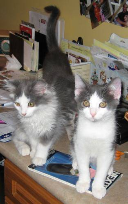

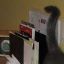

[0] 0.8687602855756525


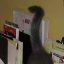

[0] 0.8980540089833157


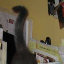

[1] 0.7887983192583331


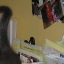

[0] 0.6399152613587458


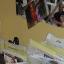

[1] 0.6178109786565139


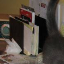

[0] 0.8894382848221283


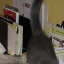

[0] 0.906750828924991
Scale ->  0 | Confidence Score 0.906750828924991 



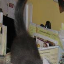

[1] 0.8877051338380598


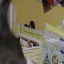

[1] 0.5241920884144731


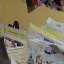

[0] 0.5880035682283213


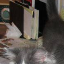

[0] 0.8725232994161461


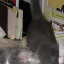

[0] 0.9529449282628184
Scale ->  0 | Confidence Score 0.9529449282628184 



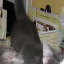

[1] 0.8953777020051619


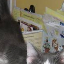

[0] 0.66286955055088


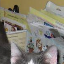

[0] 0.6104370373410797


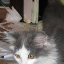

[0] 0.9805179955640096
Scale ->  0 | Confidence Score 0.9805179955640096 



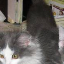

[0] 0.9961302846483593
Scale ->  0 | Confidence Score 0.9961302846483593 



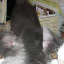

[0] 0.8858081999573777


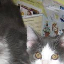

[0] 0.9289735582958802
Scale ->  0 | Confidence Score 0.9289735582958802 



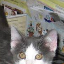

[0] 0.7961908754319469


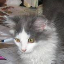

[0] 0.9948202128584974
Scale ->  0 | Confidence Score 0.9948202128584974 



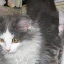

[0] 0.9995441888898925
Scale ->  0 | Confidence Score 0.9995441888898925 



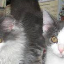

[0] 0.9983820870782403
Scale ->  0 | Confidence Score 0.9983820870782403 



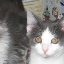

[0] 0.9962750025620469
Scale ->  0 | Confidence Score 0.9962750025620469 



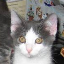

[0] 0.9879363359918863
Scale ->  0 | Confidence Score 0.9879363359918863 



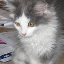

[0] 0.9936682135189
Scale ->  0 | Confidence Score 0.9936682135189 



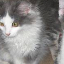

[0] 0.992864950450017
Scale ->  0 | Confidence Score 0.992864950450017 



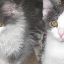

[0] 0.9990862262518072
Scale ->  0 | Confidence Score 0.9990862262518072 



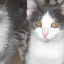

[0] 0.9964969269039485
Scale ->  0 | Confidence Score 0.9964969269039485 



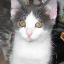

[0] 0.9819809502525926
Scale ->  0 | Confidence Score 0.9819809502525926 



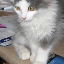

[0] 0.9443649624941661
Scale ->  0 | Confidence Score 0.9443649624941661 



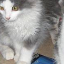

[0] 0.9515281215896616
Scale ->  0 | Confidence Score 0.9515281215896616 



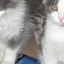

[0] 0.9980250470395845
Scale ->  0 | Confidence Score 0.9980250470395845 



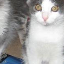

[0] 0.9976697995494799
Scale ->  0 | Confidence Score 0.9976697995494799 



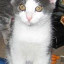

[0] 0.9981639865054031
Scale ->  0 | Confidence Score 0.9981639865054031 



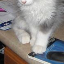

[0] 0.9894916393193538
Scale ->  0 | Confidence Score 0.9894916393193538 



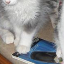

[0] 0.9803207297276842
Scale ->  0 | Confidence Score 0.9803207297276842 



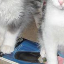

[0] 0.9983995560004888
Scale ->  0 | Confidence Score 0.9983995560004888 



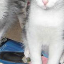

[0] 0.9990501792968833
Scale ->  0 | Confidence Score 0.9990501792968833 



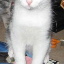

[0] 0.9944633469753864
Scale ->  0 | Confidence Score 0.9944633469753864 



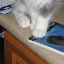

[0] 0.9747641670519216
Scale ->  0 | Confidence Score 0.9747641670519216 



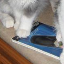

[0] 0.9475455791626731
Scale ->  0 | Confidence Score 0.9475455791626731 



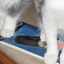

[0] 0.9583054737421889
Scale ->  0 | Confidence Score 0.9583054737421889 



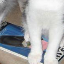

[0] 0.6123410351682448


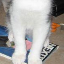

[1] 0.5240009125916923


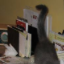

[0] 0.7924062357676047


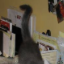

[0] 0.6462467952798133


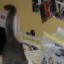

[1] 0.539054560731075


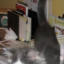

[0] 0.8442496768548231


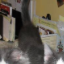

[1] 0.6995254250393599


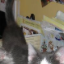

[0] 0.5203408503938205


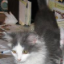

[0] 0.9800459878896499
Scale ->  1 | Confidence Score 0.9800459878896499 



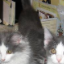

[0] 0.9411119689793154
Scale ->  1 | Confidence Score 0.9411119689793154 



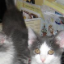

[0] 0.922465070145463
Scale ->  1 | Confidence Score 0.922465070145463 



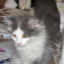

[0] 0.9801621111441585
Scale ->  1 | Confidence Score 0.9801621111441585 



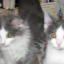

[0] 0.963968162989373
Scale ->  1 | Confidence Score 0.963968162989373 



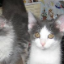

[0] 0.9692217262745855
Scale ->  1 | Confidence Score 0.9692217262745855 



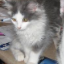

[0] 0.9786449845682946
Scale ->  1 | Confidence Score 0.9786449845682946 



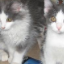

[0] 0.993619329814017
Scale ->  1 | Confidence Score 0.993619329814017 



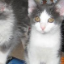

[0] 0.9943174786833623
Scale ->  1 | Confidence Score 0.9943174786833623 



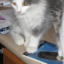

[0] 0.9534372823360405
Scale ->  1 | Confidence Score 0.9534372823360405 



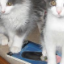

[0] 0.9910822555658908
Scale ->  1 | Confidence Score 0.9910822555658908 



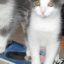

[0] 0.9974365956018719
Scale ->  1 | Confidence Score 0.9974365956018719 



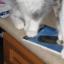

[0] 0.8938449330721475


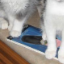

[0] 0.9852995269310573
Scale ->  1 | Confidence Score 0.9852995269310573 



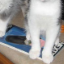

[0] 0.9832451333960112
Scale ->  1 | Confidence Score 0.9832451333960112 



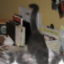

[1] 0.5671602316461162


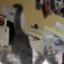

[1] 0.6441522343322252


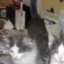

[0] 0.745362511644765


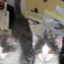

[1] 0.5082783843462747


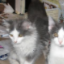

[0] 0.9888032601509785
Scale ->  2 | Confidence Score 0.9888032601509785 



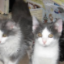

[0] 0.8955407830079839


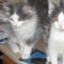

[0] 0.9980084181012817
Scale ->  2 | Confidence Score 0.9980084181012817 



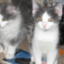

[0] 0.9842474344661979
Scale ->  2 | Confidence Score 0.9842474344661979 



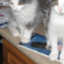

[0] 0.9990323293803951
Scale ->  2 | Confidence Score 0.9990323293803951 



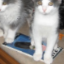

[0] 0.9990842416775
Scale ->  2 | Confidence Score 0.9990842416775 



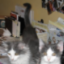

[0] 0.6962419532349532


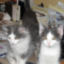

[0] 0.929409296631465
Scale ->  3 | Confidence Score 0.929409296631465 



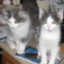

[0] 0.987293916689126
Scale ->  3 | Confidence Score 0.987293916689126 



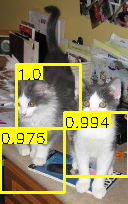

True

In [283]:
%cd /content
# init config:
MIN_WINDOW_SIZE = [128, 128]
STEP_SIZE = [32, 32]
ORIENTATIONS = 9
PIXELS_PER_CELL = [5, 5]
CELL_PER_BLOCK = [3, 3]

# hyper parameter
downscale = 1.25
conf = 0.9
nms_threshold = 0.05
input_base = 128

# read image
im = cv2.imread("cat.2236.jpg")
# cv2_imshow(im)
# print(im)
f = get_svm_input(im)
res = model.predict(f)
print(res)
if res[0] == 0:
    print("There're cats here")
else:
    print("There're no cats here")

h, w, _ = im.shape
if h > w:
    input_width = input_base
    input_height = int(input_width * h / w)
else:
    input_height = input_base
    input_width = int(input_height * w / h)
print(h, w, input_height, input_width)

min_window_size = min(input_height, input_width)
MIN_WINDOW_SIZE = [min_window_size//2, min_window_size//2]
STEP_SIZE = [min_window_size//8, min_window_size//8]

im = cv2.resize(im, (input_width, input_height))
cv2_imshow(im)

ori_img = im
detections = []
detections_v1 = []
confidence_score = []
scale = 0

for im_scaled in pyramid_gaussian(im, downscale=downscale):
    im_scaled = (im_scaled*255).astype(np.uint8)
    # cv2.imwrite("/content/blah/o_img_%.5f.jpg" % (time.time()), im_scaled)
    cd = []
    if im_scaled.shape[0] < MIN_WINDOW_SIZE[1] or im_scaled.shape[1] < MIN_WINDOW_SIZE[0]:
        break

    for (x, y, im_window) in sliding_window(im_scaled, MIN_WINDOW_SIZE, STEP_SIZE):
        if im_window.shape[0] != MIN_WINDOW_SIZE[1] or im_window.shape[1] != MIN_WINDOW_SIZE[0]:
            continue
        window = im_window

        raw_im_window = im_window
        # window = cv2.resize(window, (input_size, input_size))
        fd = get_svm_input(window)
        # print(window)
        cv2_imshow(window)
        pred, confidences = inference(model, fd)
        print(pred, confidences)
        # hiện tại mới nhận diện chó
        if pred[0] == 0:
            if confidences < conf:
                continue
            print("Scale ->  {} | Confidence Score {} \n".format(scale, confidences))
            detections.append((x, y, confidences,
                                int(MIN_WINDOW_SIZE[0] * (downscale ** scale)),
                                int(MIN_WINDOW_SIZE[1] * (downscale ** scale))))
            detections_v1.append((x, y,
                                    x + int(MIN_WINDOW_SIZE[0] * (downscale ** scale)),
                                    y + int(MIN_WINDOW_SIZE[1] * (downscale ** scale))))
            confidence_score.append(round(confidences, 3))
            cd.append(detections[-1])
        if True:
            clone = im_scaled.copy()
            for x1, y1, _, _, _ in cd:
                # Draw the detections at this scale
                cv2.rectangle(clone, (x1, y1), (x1 + raw_im_window.shape[1], y1 +
                                                raw_im_window.shape[0]), (0, 0, 0), thickness=2)
            cv2.rectangle(clone, (x, y), (x + raw_im_window.shape[1], y +
                                            raw_im_window.shape[0]), (0, 0, 0), thickness=2)
            # cv2_imshow(clone)
            # cv2.waitKey(10)
    scale += 1



# Perform Non Maxima Suppression
picked_boxes, picked_score = non_maximum_suppression(detections_v1, confidence_score, nms_threshold)
# Draw parameters
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
thickness = 1
for (start_x, start_y, end_x, end_y), confidence in zip(picked_boxes, picked_score):
    (w, h), baseline = cv2.getTextSize(str(confidence), font, font_scale, thickness)
    cv2.rectangle(ori_img, (start_x, start_y + (2 * baseline + 5)), (start_x + w, start_y), (0, 255, 255), -1)
    cv2.rectangle(ori_img, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
    cv2.putText(ori_img, str(confidence), (start_x, start_y + (2 * baseline + 5)), font, font_scale, (0, 0, 0), thickness)
# Display the results after performing NMS
# for (x_tl, y_tl, _, w, h) in detections:
#     # Draw the detections
#     cv2.rectangle(clone, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 0), thickness=2)
cv2_imshow(ori_img)
cv2.imwrite("img-%.2f.jpg" % (time.time()), ori_img)